# Gaussian Mixture Models (Clustering)

In [5]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** Sometimes our data contains hidden structure---structure that we'd like to uncover in order to answer some scientific question. For example, recall the data set we analyzed in the unit on continuous probability from IHH’s Center for Telekinesis Research (CTR). The researchers at the IHH’s CTR study the propensity of intergalactic beings for telekinesis—the ability to move objects with one's mind. They were interested in understanding how different physiological conditions affect a being’s telekinetic abilities. That is, they observed each patient's telekinetic-ability and wanted to understand how it related to some underlying condition (allergic reaction, intoxication, and entangled antennas). In their specific case, their data did contain the underlying condition. However, oftentimes, our data doesn't contain this information. In such cases, our goal is to *uncover* the underlying types of patients. Doing so may help identify patients that benefit from different treatments. For example, in addition to each patient's underlying physiological condition, their telekinetic ability could have been impacted by environmental factors growing up, their genetics, etc. It's hard to know a priori which of these factors are truly important, so it's not worth investing in collecting all this data (which is expensive). 

**Challenge:** But how can we possibly uncover a variable that's not in the data? By making assumptions about the distribution of this variable, as well as how it relates to the other variables in the data, we can! In statistical lingo, such *unobserved* variables are called *latent* variables. As we will show here, there's only one rule of probability we need to learn in order to use our existing toolkit to model latent variables. 

**Outline:** 
* Introduce latent variable models, as well as our first latent variable model (LVM)---the Gaussian Mixture Model (GMM)
* Introduce the law of total probability (in the discrete case), which will allow us to compute the MLE for LVMs
* Compute the MLE for the GMM
* Implement a GMM in `NumPyro`

**Data:** We will start by modeling the data introduced in the chapter on continuous probability. The data includes two variables---the patient's telekinetic ability, and their underlying condition. We will *pretend* that we did not observe their underlying condition. Our goal will then be to *infer* it given their telekinetic ability. Let's remind ourselves what the data looks like:

In [6]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Condition,Telekinetic-Ability
Patient ID,,
398,Allergic Reaction,0.510423
3833,Allergic Reaction,0.479960
4836,Intoxication,2.043218
4572,Allergic Reaction,-0.443333
636,Intoxication,1.423190
2545,Intoxication,1.392568
1161,Intoxication,2.110151
2230,Intoxication,2.102866
148,Intoxication,1.865081


## Latent Variable Models (LVMs)

**Overview.** Latent variable models allow us to model variables we actually did not observe. We will do this using the very same toolkit we've used so far; we'll write down a joint distribution for all variables---observed and latent---as well as a directed graphical model. We will then perform MLE on the resultant model. We will instantiate everything with a specific model---Gaussian Mixture Model (GMM)---which will help us find patient types in the above IHH data.

**Gaussian Mixture Models (GMMs).** In our IHH example, we assume the patients' underlying type in some way "explains" their observed data. We can encode this into a model by saying that each patient's data is generated by:
1. Sampling their *patient type* from some distribution. We'll call the latent type $z$, and assume it's drawn from a Categorical distribution with parameter $\pi$:
    \begin{align}
    z_n &\sim \mathrm{Cat}(\pi)
    \end{align}
2. Given the type, we can now sample the *observed data*, $x$. As the name suggests, we'll set this distribution to be a Gaussian. The Gaussian's mean and variance will be selected by $z_n$. By this we mean that if the patient has underlying type 1 (i.e. $z_n = 1$), then their observed data is sampled from $\mathcal{N}(\mu_1, \sigma^2_1)$. Similarly, if they have underlying type 2, their observed data is sampled from $\mathcal{N}(\mu_2, \sigma^2_2)$. Putting this together, we have:
    \begin{align}
    x_n | z_n &\sim \mathcal{N}(\mu_{z_n}, \sigma^2_{z_n})
    \end{align}

For 1-dimensional $x$, the final data-generating process is then:
\begin{align}
z_n &\sim p_Z(\cdot; \pi) = \mathrm{Cat}(\pi) \quad (\text{mixture})\\
x_n | z_n &\sim p_{X | Z}(\cdot | z_n; \mu_0, \dots, \mu_{K-1}, \sigma_0, \dots, \sigma_{K-1}) = \mathcal{N}(\mu_{z_n}, \sigma^2_{z_n}) \quad (\text{components})
\end{align}
The distribution over the latent variable is often called the "mixture," and each Gaussian is called a "component" in the mixture. From here on, we'll use $\theta = \{ \pi, \mu_0, \dots, \mu_{K-1}, \sigma_0, \dots, \sigma_{K-1}\}$ to refer to the model's parameters.

**Directed Graphical Model.** Graphically, we can depict a GMM as follows:

<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe"
      src="https://www.canva.com/design/DAGUsKgegMc/y2xjSpVURjxydkyjJQXerQ/view?embed">
    </iframe>
  </div>
</div>

As you can see, our observed data, $x_n$, depends on the latent patient type, $z_n$. Since $z_n$ is not observed, *its circle is left white* (i.e. not shaded in).

**What are GMMs useful for?** To better understand what GMMs are useful for, let's visualize them. Here's an example GMM:

```{figure} _static/figs/example_1d_gmm.png
---
name: fig-gmm-1d
align: center
---
The PDF of a GMM's mixture components (left) and data marginal (right).
```

On the left, you can see the GMM's mixture components (i.e. each Gaussian), and on the right, you can see the probability of the *observed* data, $p_X(\cdot; \theta)$. Looking at the above figure, you can see two things:
1. *Clustering.* Looking at the left plot, you can see that GMMs can "cluster" the observed data; every observation likely belongs to one of three Gaussians---we just need to figure out which observation belongs to which cluster.
2. *Complicated Distributions.* Looking at the right plot, you can see that GMMs can describe more complicated distributions. Unlikely the continuous distributions we've used so far, which all have one mode (or one "bump"), using a GMM we can easily describe a distribution with multiple bumps. 

**Challenges Deriving the MLE for GMMs.** Now that we have our directed graphical model and our data generating process, we can try to derive the MLE for GMMs. Unfortunately, as you will see, we'll run into some issues. Then our joint data likelihood (which we'd like to maximize) is:
\begin{align}
p(\mathcal{D}; \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \prod\limits_{n=1}^N p_X(x_n; \theta)
\end{align}
Looking at the above, what is $p_X(x_n; \theta)$? Our data-generating process gives us the following joint distribution:
\begin{align}
p_{X | Z}(x_n, z_n; \theta) &= p_{X | Z}(x_n | z_n; \theta) \cdot p_Z(z_n; \theta)
\end{align}
Somehow, we need to compute $p_X(x_n; \theta)$ from $p_{X | Z}(x_n, z_n; \theta)$. 

As we will show next, we can compute $p_X(x_n; \theta)$ as follows:
\begin{align}
p_X(x_n; \theta) &= \sum\limits_{z_n \in S} p_{X, Z}(x_n, z_n; \theta),
\end{align}
where $S = \{0, \dots, K - 1 \}$ is the support of $Z$, and $K$ is the number of clusters. This formula shows that we can compute $p_X(x_n; \theta)$ by summing the joint over every value of $z_n$. 

## The Law of Total Probability (Discrete)

**Definition.** The law of total probability tells us how to compute a marginal distribution from a joint distribution. Suppose you have two random variables, $A$ and $B$, and suppose that $A$ is discrete with support $S$. Then the law of total probability says we can compute the marginal $p_B(b)$ from the joint $p_{A, B}(a, b)$ as follows:
\begin{align}
p_B(b) &= \sum\limits_{a \in S} p_{A, B}(a, b)
\end{align}
We can also write it using expectations by factorizing the joint distribution:
\begin{align}
p_B(b) &= \sum\limits_{a \in S} p_{A, B}(a, b) \\
&= \sum\limits_{a \in S} p_{B | A}(b | a) \cdot p_A(a) \\
&= \mathbb{E}_{a \sim p_A(\cdot)} \left[ p_{B | A}(b | a) \right] \\
\end{align}
The law of total probability says that the probability of $B$ is that of $B$ given $A = a$, averaged over all values of $a$. 

**Lingo.** Since saying "law of total probability" is a mouthful, we typically say "marginalize out." So in the above example, we *marginalized out* $A$. 

**Intuition.** To get intuition, let's depict $A$ and $B$ as follows, each with support $S = \{0, 1\}$:

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGMdzJ3f3k&#x2F;PhWElQiQSXIIPklC6ED39w&#x2F;view?embed">
  </iframe>
</div>
</div>

In this diagram, each shaded area represents the probability of an event---i.e. area is proportional to probability. The marginal probability of $B = 1$ is therefore the ratio of the blue square relative to the whole space (the gray square):

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGMdw0ybko&#x2F;3Aap1TJZMrHHD8kPFhfEzQ&#x2F;view?embed">
  </iframe>
</div>
</div>

Using the law of total probability, we can equivalently compute the marginal probability $p_B(1)$ as follows:
\begin{align}
p_B(1) &= \sum\limits_{a \in S} p_{A, B}(a, 1) \\
&= p_{A, B}(0, 1) + p_{A, B}(1, 1) \\
\end{align}
Re-writing this equation visually, we get:

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGMdzAtxTY&#x2F;406MzXJ_IH4tJuHLwoYFEg&#x2F;view?embed">
  </iframe>
</div>
</div>

As you can see from the diagram, this formula holds. Now let's add to our pictoral intuition by assigning meaning to $A$ and $B$. Suppose $B = 1$ is the event in which a patient has pneumonia ($B = 0$ implies they don't have pneumonia), and suppose that $A = 1$ is the event of rain. We can attribute meaning to the law of total probability as follows:
\begin{align}
\underbrace{p_B(1)}_{\text{has pneumonia}} &= \underbrace{p_{A, B}(0, 1)}_{\text{has pneumonia and no rain}} + \underbrace{p_{A, B}(1, 1)}_{\text{has pneumonia and rain}}
\end{align}
As you can see, the formula aggregates the probability of a patient having pneumonia across all possible scenarios---rain or no rain. 

## MLE for GMMs

**MLE Objective.** Using the law of total probability, we can now write our MLE objective:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_\theta \log p(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_\theta \log \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p_X(x_n; \theta) \\
&= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log \sum\limits_{z_n \in S} p_{X, Z}(x_n, z_n; \theta) \\
\end{align}

**Optimization.** We can optimize the GMM's MLE objective using gradient descent, as we've done for every other model so far. However, note that in practice, there's a much better algorithm to perform this optimization. This algorithm is called [Expectation Maximization (EM)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), and it converges faster and better avoids local optima. We will unfortunately not get into the details of this algorithm. 

```{admonition} Exercise: Law of Total Probability

**Part 1:** Suppose you have three random variables, $A$, $B$, and $C$, with supports $S_A$, $S_B$, and $S_C$. Using the law of total probability, how would you compute the following probabilities?

a. You are given a distribution, $p_{A, B, C}(a, b, c)$. Compute $p_{A, B}(a, b)$.

b. You are given a distribution, $p_{A, B, C}(a, b, c)$. Compute $p_{A}(a)$.

c. You are given a distribution, $p_{A, B | C}(a, b | c)$. Compute $p_{A | C}(a | c)$.


**Part 2:** Consider the following graphical model, in which the support of $z_{m, n}$ is $S = \{ 0 , 1 \}$.

<div class="canva-centered-embedding">
<div class="canva-iframe-container">
  <iframe loading="lazy" class="canva-iframe"
    src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGMeBRCjYo&#x2F;drP9yh18Xe8SP3N23hfB9g&#x2F;view?embed">
  </iframe>
</div>
</div>

a. Which variable here is a latent variable, and how do you know?

b. Write down the MLE objective when $M = 2$ and $M = 3$.

c. In general, how many elements need to be summed over in the MLE objective (as a function of $N$ and $M$)? What does this tell you about including lots of latent variables in your model?
```

## Multivariate GMMs

When given low dimensional data, we can often inspect it (by visualizing it) to determine what types of hidden structures (e.g. clusters) exist. However, in higher dimensional data, this is no longer possible. In our GMM model, above, we've used 1-dimensional Gaussian distributions (for one-dimensional observed data). To work with higher dimensional data, we can use a [*multivariate* Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). A multivariate Gaussian allows us to write down a single formula for a collection of random variables, whose *joint* distribution is Gaussian. 

A multivariate Gaussian requires two parameters: a mean, $\mu$, and a covariance, $\Sigma$. The mean plays the same role as it does in the univariate case---it is the center of the distribution. For example, suppose we have a 2-dimensional multivariate Gaussian over random variables $X_1$ and $X_2$. And suppose their mean,
\begin{align}
\mu &= \begin{bmatrix} -1.0 \\ 1.0 \end{bmatrix},
\end{align}
then the distribution of $X_1$ will be centered at $-1.0$ and the distribution of $X_2$ will be centered at $1.0$. 

Next, the covariance plays the same role as the variance (or standard deviation)---it tells us about the spread of the distribution around its mean. In the multivariate case, you can think of the covariance as telling us how pairs of variables correlate. For example,
\begin{align}
\Sigma &= \begin{bmatrix} 2.0 & 0.9 \\ 0.9 & 1.0 \end{bmatrix}.
\end{align}
The values along the diagonal, $2.0$ and $1.0$, tell us about the variance (or spread) of $X_1$ and $X_2$, respectively. Specifically, they tell us that $X_1$ is more spread out than $X_2$. The values in the off-diagonal tell us about how the variables correlate. A value of $0.9$ indicates $X_1$ and $X_2$ correlate more strongly than a value of $0.0$ (which indicates no correlation, i.e. independence). Note that $\Sigma$ needs to satisfy certain properties; for example, it needs to be *symmetric* (since $X_1$ covaries with $X_2$ as much as $X_2$ covaries with $X_1$). 

Let's get more intuition by creating some multivariate Gaussians and visualizing their samples. But first, let's import stuff!

In [7]:
import matplotlib.pylab as plt
import jax.numpy as jnp
import jax.random as jrandom
import numpyro.distributions as D

Now we will visualize samples from a 2-dimensional multivariate Gaussian with the above mean and covariance:
\begin{align}
\begin{bmatrix} X_1 \\ X_2 \end{bmatrix} 
\sim \mathcal{N}\left( 
\begin{bmatrix} -1.0 \\ 1.0 \end{bmatrix},
\begin{bmatrix} 2.0 & 0.9 \\ 0.9 & 1.0 \end{bmatrix}
\right)
\end{align}

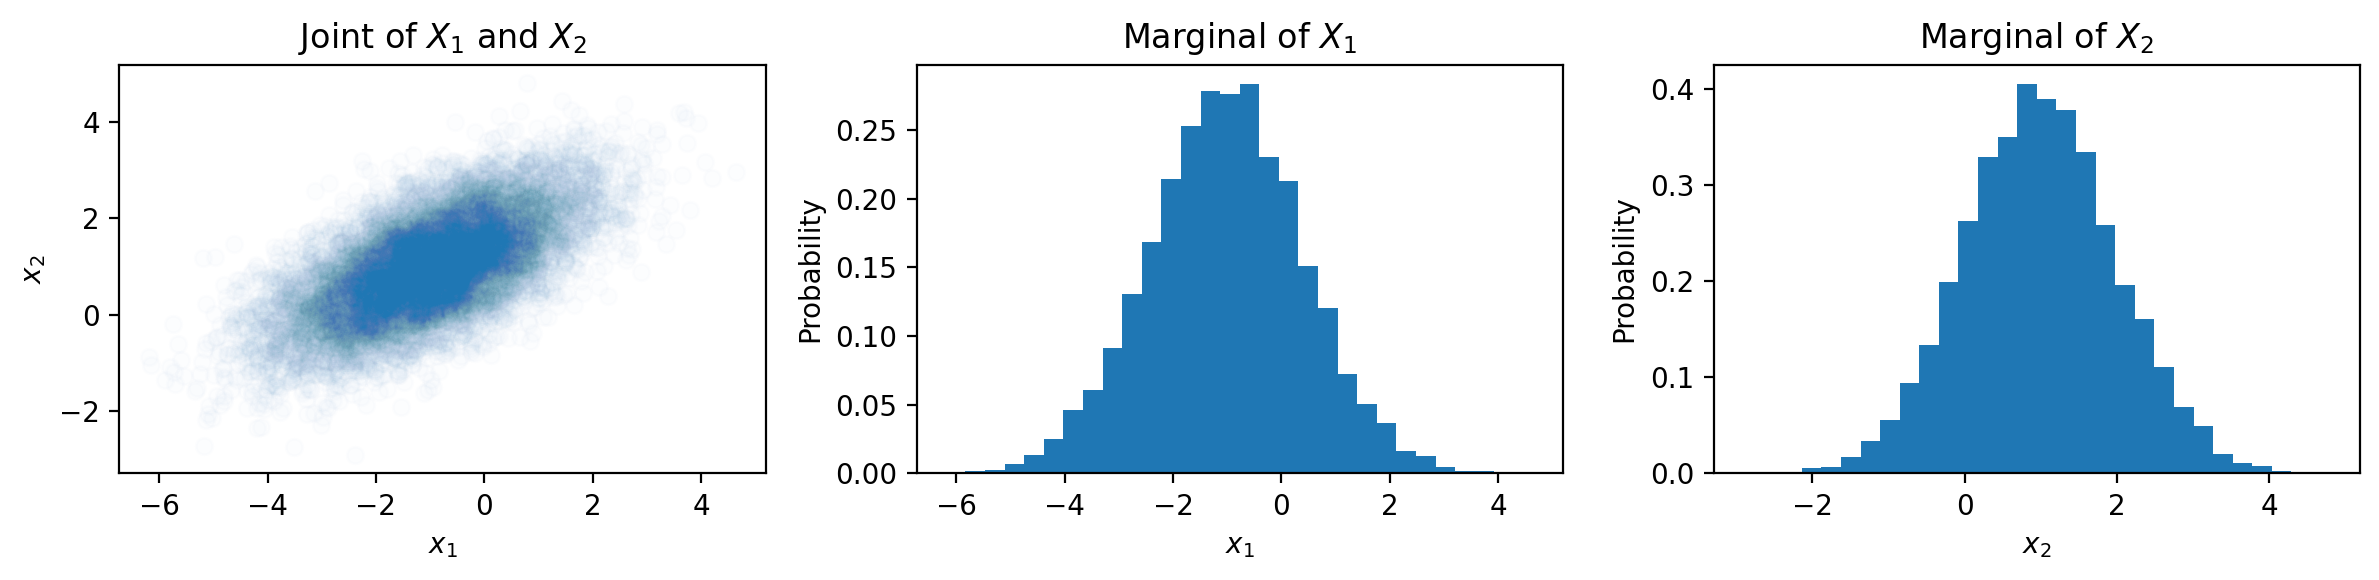

In [8]:
# Define mean and covariance
mean = jnp.array([-1.0, 1.0])
cov = jnp.array([[2.0, 0.9], [0.9, 1.0]])

# Create a multivariate gaussian
mvn = D.MultivariateNormal(mean, cov)

# Sample
key = jrandom.PRNGKey(seed=0)
samples = mvn.sample(key, (10000,))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the joint distribution of X_1 and X_2
axes[0].scatter(samples[:, 0], samples[:, 1], alpha=0.01)
axes[0].set_xlabel(r'$x_1$')
axes[0].set_ylabel(r'$x_2$')
axes[0].set_title('Joint of $X_1$ and $X_2$')

# Plot the distribution of X_1
axes[1].hist(samples[:, 0], bins=30, density=True)
axes[1].set_xlabel(r'$x_1$')
axes[1].set_ylabel('Probability')
axes[1].set_title(r'Marginal of $X_1$')

# Plot the distribution of X_2
axes[2].hist(samples[:, 1], bins=30, density=True)
axes[2].set_xlabel(r'$x_2$')
axes[2].set_ylabel('Probability')
axes[2].set_title(r'Marginal of $X_2$')

plt.tight_layout()
plt.show()

To extend GMMs to multivariate data, we can replace the univariate Gaussian components in our model with multivariate Gaussians. Using the MLE, we can learn the parameters, $\mu$ and $\Sigma$, of each Gaussian.

## Fitting GMMs to Data

**GMMs in `NumPyro`.** To fit a GMM using `NumPyro`, we have to explicitly marginalize out the discrete latent variable. While it's possible to do this, we find that it tends to be a little finicky. As a result, we will show you how to write the model in `NumPyro` instead of implementing it yourself. We'll then have you play with an existing implementation to gain intuition. 

```
def univariate_gmm(N, x=None, K=3):
    # Parameter for the mixing distribution
    pi = numpyro.param(
        'pi',
        init_value=jnp.ones(K) / float(K),
        constaint=C.simplex,
    )

    # Parameter for the means of the Gaussian components
    # For optimization purposes, we initialize the means to some random samples
    mu = numpyro.param(
        'mu',
        lambda key: 0.1 * jrandom.normal(key, shape=(K,)), 
        constaint=C.real,
    )

    # Parameter for the standard deviations of the Gaussian components
    # For optimization purposes, we initialize the means to some random samples
    std_dev = numpyro.param(
        'mu',
        lambda key: 0.1 * jrandom.normal(key, shape=(K,)) ** 2.0, 
        constaint=C.positive,
    )    

    # We create a plate for the number of observations
    with numpyro.plate('data', N):
        # For each observation, we first sample its "cluster" or "type"
        p_z = D.Categorical(pi)
        z = numpyro.sample('z', p_z)

        # Using the cluster, we choose a Gaussian component to sample from
        p_x_given_z = D.Normal(mu[z], std_dev[z])
        numpyro.sample('x', p_x_given_z, obs=x)
```

As you can see, this model is a direct translation of our data generating process. Notice that the line that samples `z` does not have a keyword argument `obs=`. This is because we have not observed `z` (it's latent). 

````{admonition} Exercise: Fitting GMMs to Data

**Part 1:** We'll use an existing implementation of GMMs from `Scikit-Learn`. You can import the model as follows:
```
from sklearn.mixture import GaussianMixture
```
Then, following the example in their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture), fit the data to the IHH data set above. 

**Part 2:** Using a histogram, visualize the IHH's data and samples generated by the fitted model. Do they look the same? If not, figure out what went wrong and retry!

**Part 3:** Using the `predict` method, determine the most likely "cluster" for each patient. Then compare against the ground-truth `Condition` in the data. How well do the two match? If they do not match perfectly, why?

**Part 4:** Unfortunately, an unknown epidemic hit the IHH hard this week. Clinicians at the IHH's Center for Epidemiology have been working around the clock to try to understand the nature of the disease. They have collected data about patient symptoms---fever and heart-rate---that they were hoping would help them see if there are any underlying patient types. They have obtained an initial sample of data (already normalized): `'data/IHH-CE-clustering.csv'`. Fit a bunch of GMMs to the data, varying their number of components and their random seed. Then, visualize the model against the data. You can visualize the data by scatter plotting it, with color corresponding to the predicted cluster. How many types of patients did you identify? How do you know? 

**Part 5:** Clinicians at the IHH's sister hospital have been trying to understand a similar epidemic that hit their hospital. They have collected a similar data set (already normalized) and have asked you to investigate it: `'data/IHH-sister-CE-clustering.csv'`. Like before, fit a GMM to the data and visualize the model against the data. How many types of patients did you identify? How do you know?
````